In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline
np.random.seed(0)

In [2]:
df = pd.read_csv("/content/drive/MyDrive/ner_dataset.csv", encoding= 'unicode_escape')
df = df.fillna(method = "ffill")
df.head(23)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
words = list(set(df["Word"].values))
words.append("ENDPAD")
n_words = len(words)
words

['thawing',
 'private-sector',
 'Super',
 'ASEAN',
 'mortal',
 'Friedan',
 'cafe',
 '325',
 'Dakota',
 'pacts',
 'about',
 'Rockets',
 'transferring',
 'credits',
 'wife',
 'bombardment',
 'seeking',
 'Bet',
 'confiscated',
 '11-year-old',
 'overthrowing',
 'complicated',
 'soundly',
 'seeds',
 'objectionable',
 'Baladiyat',
 'loss',
 'Sadiq',
 'fouled',
 'Harmeet',
 'settlers',
 'Ninevah',
 'Leader',
 'Yoadimadji',
 'Hemispheres',
 'refinances',
 'exile',
 'faction-ridden',
 '447',
 'radar',
 'Zahir',
 'Chuprun',
 'Scotia',
 'impunity',
 'opening-day',
 'swung',
 'subsidized',
 'sightings',
 '715',
 'filthy',
 'assortment',
 'Sanders',
 'inspired',
 'under',
 'discover',
 'Irrawaddy',
 'extricate',
 'tunnels',
 'Ceylon',
 'whatever',
 'blatantly',
 'inferior',
 'trouble',
 'Nambiar',
 'Khyber-Pakhtunkhwa',
 'offloaded',
 'govern',
 'Condoleeza',
 'indoors',
 'Globovision',
 'morning',
 'clears',
 'carcasses',
 'unvarnished',
 'depleted',
 'Frenchman',
 'Glenn',
 'BORU',
 'Hernan',
 'e

In [4]:
tags = list(set(df['Tag'].values))
n_tags = len(tags)

In [5]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
sentences = SentenceGetter(df).sentences
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [7]:
word_to_idx = {w: i + 1 for i,w in enumerate(words)}
tag_to_idx= {t: i for i,t in enumerate(tags)}

In [8]:
display(tag_to_idx, word_to_idx)

{'B-art': 9,
 'B-eve': 15,
 'B-geo': 14,
 'B-gpe': 5,
 'B-nat': 8,
 'B-org': 13,
 'B-per': 4,
 'B-tim': 1,
 'I-art': 10,
 'I-eve': 0,
 'I-geo': 16,
 'I-gpe': 2,
 'I-nat': 6,
 'I-org': 3,
 'I-per': 11,
 'I-tim': 7,
 'O': 12}

{'thawing': 1,
 'private-sector': 2,
 'Super': 3,
 'ASEAN': 4,
 'mortal': 5,
 'Friedan': 6,
 'cafe': 7,
 '325': 8,
 'Dakota': 9,
 'pacts': 10,
 'about': 11,
 'Rockets': 12,
 'transferring': 13,
 'credits': 14,
 'wife': 15,
 'bombardment': 16,
 'seeking': 17,
 'Bet': 18,
 'confiscated': 19,
 '11-year-old': 20,
 'overthrowing': 21,
 'complicated': 22,
 'soundly': 23,
 'seeds': 24,
 'objectionable': 25,
 'Baladiyat': 26,
 'loss': 27,
 'Sadiq': 28,
 'fouled': 29,
 'Harmeet': 30,
 'settlers': 31,
 'Ninevah': 32,
 'Leader': 33,
 'Yoadimadji': 34,
 'Hemispheres': 35,
 'refinances': 36,
 'exile': 37,
 'faction-ridden': 38,
 '447': 39,
 'radar': 40,
 'Zahir': 41,
 'Chuprun': 42,
 'Scotia': 43,
 'impunity': 44,
 'opening-day': 45,
 'swung': 46,
 'subsidized': 47,
 'sightings': 48,
 '715': 49,
 'filthy': 50,
 'assortment': 51,
 'Sanders': 52,
 'inspired': 53,
 'under': 54,
 'discover': 55,
 'Irrawaddy': 56,
 'extricate': 57,
 'tunnels': 58,
 'Ceylon': 59,
 'whatever': 60,
 'blatantly': 61,
 'infe

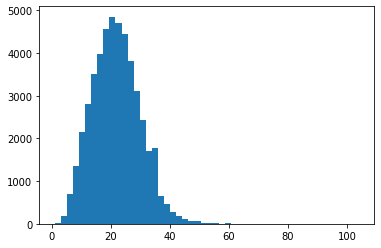

In [9]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [10]:
max_len = 50

X = [[word_to_idx[w[0]] for w in s] for s in sentences]
X = tf.keras.preprocessing.sequence.pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

y = [[tag_to_idx[w[2]] for w in s] for s in sentences]
y = tf.keras.preprocessing.sequence.pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag_to_idx["O"])

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [12]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [13]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
chkpt = ModelCheckpoint("ner_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
1199/1199 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9586
Epoch 1: val_loss improved from inf to 0.06560, saving model to ner_weights.h5
1199/1199 [==============================] - 424s 346ms/step - loss: 0.1798 - accuracy: 0.9586 - val_loss: 0.0656 - val_accuracy: 0.9813
Epoch 2/30
1199/1199 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9851
Epoch 2: val_loss improved from 0.06560 to 0.05189, saving model to ner_weights.h5
1199/1199 [==============================] - 402s 335ms/step - loss: 0.0502 - accuracy: 0.9851 - val_loss: 0.0519 - val_accuracy: 0.9846
Epoch 3/30
1199/1199 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9887
Epoch 3: val_loss improved from 0.05189 to 0.04884, saving model to ner_weights.h5
1199/1199 [==============================] - 400s 334ms/step - loss: 0.0372 - accuracy: 0.9887 - val_loss: 0.0488 - val_accuracy: 0.9856
Epoch 4/30
1199/1199 [============================

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

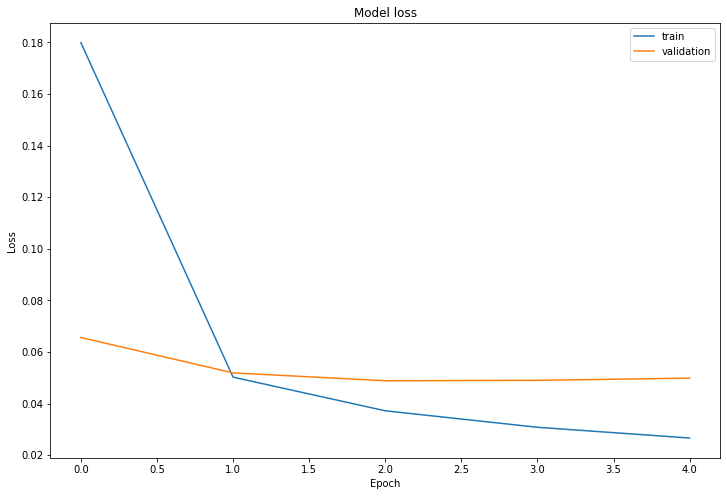

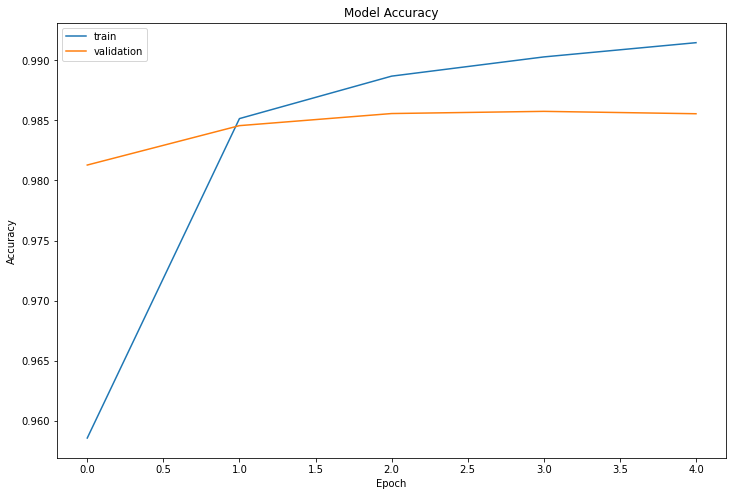

In [16]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [17]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 9s 28ms/step - loss: 0.0498 - accuracy: 0.9855


[0.04984587803483009, 0.9855483770370483]

In [19]:
display(X,y)

array([[  506,  4144, 15808, ..., 35178, 35178, 35178],
       [20632,  9325, 14743, ..., 35178, 35178, 35178],
       [22262, 12326,   527, ..., 35178, 35178, 35178],
       ...,
       [27103, 28560,  1403, ..., 35178, 35178, 35178],
       [14749, 18980,  2526, ..., 35178, 35178, 35178],
       [ 3677, 26694, 27040, ..., 35178, 35178, 35178]], dtype=int32)

array([[12, 12, 12, ..., 12, 12, 12],
       [ 5, 12, 12, ..., 12, 12, 12],
       [12, 12,  1, ..., 12, 12, 12],
       ...,
       [12, 14, 12, ..., 12, 12, 12],
       [12, 12, 12, ..., 12, 12, 12],
       [12, 13,  3, ..., 12, 12, 12]], dtype=int32)